# Impact Classifier

The project proposes to leverage machine learning (ML) and natural language processing (NLP) techniques to build a text classifier that automatizes the processing and identification of evidence of social impact in research documents. The proposal aims to solve a classification problem in which the model takes a sentence contained in a research document as input and produces as output a binary answer (1=True, 0=False) that states whether the sentence contains or not evidence of social impact, respectively.

## Load libraries

In [1]:
# import libraries
import numpy as np
import nltk
import os
import pandas as pd
import pickle
import re


# nltk.download("stopwords")

from bs4 import BeautifulSoup
import joblib
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

### Impact sentences

In [2]:
# import data
impact_sentences = pd.read_csv("data/sentences/impact_sentences.csv", usecols=['sentence'])

#### Add label column

In [3]:
impact_sentences['label'] = 1

In [4]:
impact_sentences.shape

(206, 2)

In [5]:
impact_sentences.head()

,sentence,label
0,widely featured in the national press and rad...,1
1,indeed one of these projects has been select...,1
2,impact public engagement and education influen...,1
3,reach worldwide dolly became a scientific icon...,1
4,the educational tools have been used by 11 000...,1


### General sentences

In [6]:
gral_sentences = pd.read_csv("data/sentences/gral_sentences.csv", index_col=0)

#### Add label column

In [7]:
gral_sentences['label'] = 0

In [8]:
gral_sentences.shape

(800, 2)

In [9]:
gral_sentences.head()

,sentence,label
0,notably lncrnas are known to coordinate aggres...,0
1,given these complexities a general framework f...,0
2,it has been proposed that tumors with similar ...,0
3,we also excluded an additional patient for who...,0
4,although our report does not address the expre...,0


### Merge datasets of sentences

In [10]:
total_sentences = pd.concat([impact_sentences, gral_sentences], ignore_index=True)

In [11]:
total_sentences.shape

(1006, 2)

In [12]:
total_sentences.head()

,sentence,label
0,widely featured in the national press and rad...,1
1,indeed one of these projects has been select...,1
2,impact public engagement and education influen...,1
3,reach worldwide dolly became a scientific icon...,1
4,the educational tools have been used by 11 000...,1


## Explore data

In [13]:
word_black_list = ['research', 'impact', 'uk']
max_items_to_show = 30

Inspect the most used terms used in sentences that **express** evidence of social impact

In [14]:
si_sentences = total_sentences[total_sentences['label']==1]['sentence']
si_words = []
for si_sentence in si_sentences:
    for word in si_sentence.split():
        if len(word) > 2 and word not in word_black_list and word not in stopwords.words('english'):
            si_words.append(word)
fdist = FreqDist(si_words)
freq_words_df = pd.DataFrame(fdist.items(), columns=['word', 'frequency'])

In [15]:
freq_words_df.sort_values(by='frequency', ascending=False, inplace=True)

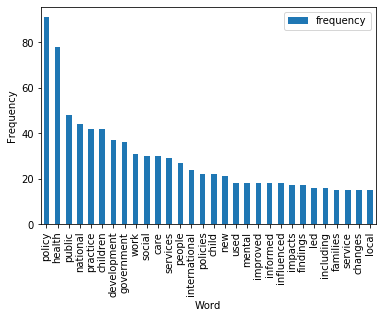

In [16]:
freq_words_df.iloc[0:max_items_to_show,:].plot(x='word', y='frequency', kind='bar')
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.show()

Inspect the most used terms in general sentences, which are assummed **do not express** evidence of social impact

In [17]:
n_si_sentences = total_sentences[total_sentences['label']==0]['sentence']
n_fdist = FreqDist(word for n_si_sentence in n_si_sentences 
                        for word in n_si_sentence.split() if len(word) > 2 and word not in stopwords.words('english') and word not in word_black_list)
n_freq_words_df = pd.DataFrame(n_fdist.items(), columns=['word', 'frequency'])

In [18]:
n_freq_words_df.sort_values(by='frequency', ascending=False, inplace=True)

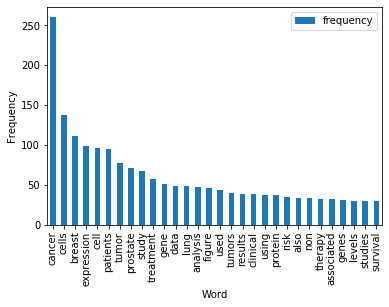

In [19]:
n_freq_words_df.iloc[0:max_items_to_show,:].plot(x='word', y='frequency', kind='bar')
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.show()

## Preparing data

Store sentences and labels into separate variables

In [22]:
data, labels = total_sentences['sentence'], total_sentences['label']

Remove any html formatting and any non-alpha numeric characters that may appear in the sentences

In [21]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def sentence_to_words(sentence, steeming=False, lemmatization=False):
    text = BeautifulSoup(sentence, "html.parser").get_text() # Remove HTML tags
    words = word_tokenize(text)   # Split string into words
    words = [word for word in words if word not in stopwords.words("english")] # Remove stopwords
    if steeming:
        words = [stemmer.stem(word) for word in words]
    if lemmatization:
        words = [lemmatizer.lemmatize(word) for word in words]
    
    return words

In [23]:
data_clean = [sentence_to_words(sentence) for sentence in data]  

In [25]:
data_steeming = [sentence_to_words(sentence, steeming=True) for sentence in data]

In [26]:
data_lemmatization = [sentence_to_words(sentence, lemmatization=True) for sentence in data]

In [27]:
data_steeming_lemmatization = [sentence_to_words(sentence, True, True) for sentence in data]

In [32]:
preprocess_data = {
    'clean': data_clean,
    'clean_steeming': data_steeming,
    'clean_lemmatization': data_lemmatization,
    'clean_steeming_lemmatization': data_steeming_lemmatization
}

Check preprocess data

In [33]:
preprocess_data['clean'][0]

['widely',
 'featured',
 'national',
 'press',
 'radio',
 'actively',
 'engaged',
 '20',
 '000',
 'members',
 'public',
 'primary',
 'scientific',
 'research',
 'including',
 '3',
 '500',
 'super',
 'engagers',
 'sent',
 'detailed',
 'records',
 'samples']

### Transform to Bag-of-Words Representation

Transform each sentence into a Bag-of-Words feature representation.

In [29]:
def extract_BoW_features(sentences, max_features=None,
                          transformation='tc',  # it can be either 'tc' (term_count), 'tf', or 'tfidf'
                          ngram_range=(1,1)):
    if transformation == 'tc':
        vectorizer = CountVectorizer(max_features=max_features, ngram_range=ngram_range, 
                                     preprocessor=lambda x: x, tokenizer=lambda x: x,
                                     lowercase=False)
    elif transformation == 'tf':
        vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range, 
                                     preprocessor=lambda x: x, tokenizer=lambda x: x,
                                     use_idf=False, lowercase=False)
    elif transformation == 'tfidf':
        vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range, 
                                     preprocessor=lambda x: x, tokenizer=lambda x: x,
                                     lowercase=False)
    bow_features = vectorizer.fit_transform(sentences).toarray()
    
    return bow_features, vectorizer.vocabulary_

#### Text transformations

In [44]:
# define conditions
transformations = ['tc', 'tf', 'tfidf']
transformed_txts = []
max_features=[100, 200, 400, 500, 800]
ngram_ranges=[(1,1),(1,2),(1,3)]

In [46]:
%%timeit
for transformation in transformations:
    for max_feature in max_features:
        for ngram_range in ngram_ranges:
            for data_type, data in preprocess_data.items():
                transformed_data, _ = extract_BoW_features(data, max_feature, transformation, ngram_range)
                transformed_txts.append(
                    {
                        'transformation': transformation,
                        'max_features': max_feature,
                        'ngram_range': ngram_range,
                        'data': transformed_data,
                        'data_type': data_type
                    }
                )

9.7 s ± 227 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's do some sanity check

In [47]:
transformed_txts[0]

{'transformation': 'tc',
 'max_features': 100,
 'ngram_range': (1, 1),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 'data_type': 'clean'}

## Train and test ML algorithms with the differente text transformations

Trainining, testing, and validating machine learning algorithms that are reported to perform well on unbalanced, small, and textual datasets.

In [48]:
def get_classifier(algorithm_name):
    if algorithm_name == 'NB':
        classifier = GaussianNB()
    elif algorithm_name == 'SVMR':
        classifier = SVC(kernel='rbf', gamma='auto')
    elif algorithm_name == 'SVML':
        classifier = SVC(kernel='linear', gamma='auto')
    elif algorithm_name == 'LR1':
        classifier = LogisticRegression(penalty='l1', solver='liblinear')
    elif algorithm_name == 'LR2':
        classifier = LogisticRegression(penalty='l2', solver='liblinear')
    elif algorithm_name == 'RF':
        params = {
            'n_estimators': 600,
            'min_samples_split': 5,
            'min_samples_leaf': 1,
            'max_features': 'auto',
            'max_depth': 50,
            'bootstrap': True
        }
        classifier = RandomForestClassifier(**params)
    elif algorithm_name == 'XGB':
        classifier = XGBClassifier(objective="binary:logistic", eta=0.2, gamma=4, min_child_weight=6)
    else:
        print("Unknown algorithm: {0}",format(algorithm_name))

    return classifier

In [49]:
def do_cross_validation(kfold, classifier, data, labels):
    scores = {
        'balanced_accuracy': [],
        'f1': [],
        'recall': [],
        'precision': []
    }
    for train_index, test_index in kfold.split(data):   
        kf_X_train, kf_X_test = data[train_index], data[test_index]
        kf_y_train, kf_y_test = labels[train_index], labels[test_index]        
        classifier.fit(kf_X_train, kf_y_train)
        y_pred = classifier.predict(kf_X_test)
        scores['balanced_accuracy'].append(metrics.balanced_accuracy_score(kf_y_test, y_pred))
        scores['f1'].append(metrics.f1_score(kf_y_test, y_pred))
        scores['recall'].append(metrics.recall_score(kf_y_test, y_pred))
        scores['precision'].append(metrics.precision_score(kf_y_test, y_pred))
    return scores

In [ ]:
%%time

from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
algorithms = ['NB', 'SVMR', 'SVML', 'LR1', 'LR2', 'RF', 'XGB']
outputs = []

for transformed_txt in transformed_txts:
    t_data = transformed_txt['data']
    transformation = transformed_txt['transformation']
    max_features = transformed_txt['max_features']
    ngram_range = str(transformed_txt['ngram_range'])
    data_type = transformed_txt['data_type']
    for algorithm in algorithms:
        print('Transformation: {0}, Max Features: {1}, NGram-range: {2}, Algorithm: {3}'.\
              format(transformation, max_features, ngram_range, algorithm))
        classifier = get_classifier(algorithm)
        scores = do_cross_validation(kfold, classifier, t_data, labels)
        outputs.append(
            {
                'algorithm': algorithm,
                'transformation': transformation,
                'max_features': max_features,
                'metrics': scores,
                'ngram_range': ngram_range,
                'data_type': data_type
            }
        )

Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max F

Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max F

Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Fe

Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformat

Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max F

Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max F

Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformat

Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max F

Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max F

Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformat

Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max F

Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max F

Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformat

Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max F

Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max F

Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformat

Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max F

Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max F

Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformat

Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max F

Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max F

Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tc, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Fe

/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 100, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 200, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 400, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 500, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 1), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 2), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: NB
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: SVML
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR1
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: LR2
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: RF
Transformation: tfidf, Max Features: 800, NGram-range: (1, 3), Algorithm: XGB
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: SVMR
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 100, NGram-range: (1, 1), Algorithm: NB
Transformat

Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: NB
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: SVMR
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: SVML
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: LR1
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: LR2
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: RF
Transformation: tc, Max Features: 200, NGram-range: (1, 1), Algorithm: XGB
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 200, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max F

Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: NB
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: SVMR
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: SVML
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: LR1
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: LR2
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: RF
Transformation: tc, Max Features: 400, NGram-range: (1, 2), Algorithm: XGB
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: NB
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: SVMR
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: SVML
Transformation: tc, Max Features: 400, NGram-range: (1, 3), Algorithm: LR1
Transformation: tc, Max F

Save results into a dataframe

In [37]:
output_df = pd.DataFrame(columns=['algorithm', 'transformation', 'max_features', 'ngram_range', 'data_type', 
                                  'mean_balanced_accuracy', 'mean_recall', 'mean_precision', 'mean_f1'])
for output in outputs:
    row = {
        'algorithm': output['algorithm'],
        'transformation': output['transformation'],
        'max_features': output['max_features'],
        'ngram_range': output['ngram_range'],
        'data_type': output['data_type'],
        'mean_balanced_accuracy': round(np.array(output['metrics']['balanced_accuracy']).mean(), 2),
        'mean_recall': round(np.array(output['metrics']['recall']).mean(), 2),
        'mean_precision': round(np.array(output['metrics']['precision']).mean(), 2),
        'mean_f1': round(np.array(output['metrics']['f1']).mean(), 2),
    }
    output_df = output_df.append(row, ignore_index=True)

In [38]:
output_df.head()

,algorithm,transformation,max_features,mean_balanced_accuracy,mean_recall,mean_precision,mean_f1
0,NB,tc,800,0.80,0.95,0.40,0.56
1,SVMR,tc,800,0.84,0.69,0.96,0.80
2,SVML,tc,800,0.93,0.88,0.92,0.89
3,LR1,tc,800,0.91,0.83,0.94,0.88
4,LR2,tc,800,0.90,0.82,0.96,0.88


Look at the top-5 models by `Balanced Accuracy`

In [39]:
output_df.sort_values(by='mean_balanced_accuracy', ascending=False).head(5)

,algorithm,transformation,max_features,mean_balanced_accuracy,mean_recall,mean_precision,mean_f1
275,SVML,tfidf,800,0.96,0.93,0.95,0.94
198,SVML,tf,800,0.96,0.93,0.96,0.94
271,RF,tfidf,800,0.96,0.93,0.93,0.93
303,SVML,tfidf,800,0.96,0.92,0.97,0.94
282,SVML,tfidf,800,0.96,0.93,0.95,0.94


Inspect the top-5 models by `Recall`

In [40]:
output_df.sort_values(by='mean_recall', ascending=False).head(5)

,algorithm,transformation,max_features,mean_balanced_accuracy,mean_recall,mean_precision,mean_f1
0,NB,tc,800,0.80,0.95,0.40,0.56
203,NB,tf,800,0.94,0.95,0.77,0.85
175,NB,tf,800,0.92,0.95,0.68,0.78
168,NB,tf,800,0.92,0.95,0.68,0.79
119,NB,tf,800,0.82,0.95,0.43,0.59


Inspect the top-5 models by `Precision`

In [41]:
output_df.sort_values(by='mean_precision', ascending=False).head(5)

,algorithm,transformation,max_features,mean_balanced_accuracy,mean_recall,mean_precision,mean_f1
71,SVMR,tc,800,0.6,0.19,1.00,0.31
78,SVMR,tc,800,0.6,0.19,1.00,0.31
64,SVMR,tc,800,0.6,0.19,1.00,0.31
305,LR2,tfidf,800,0.9,0.80,0.99,0.88
312,LR2,tfidf,800,0.9,0.80,0.99,0.88


Inspect the top-5 models by `F1`

In [42]:
output_df.sort_values(by='mean_f1', ascending=False).head(5)

,algorithm,transformation,max_features,mean_balanced_accuracy,mean_recall,mean_precision,mean_f1
191,SVML,tf,800,0.96,0.93,0.96,0.94
292,RF,tfidf,800,0.96,0.94,0.94,0.94
289,SVML,tfidf,800,0.96,0.93,0.95,0.94
299,RF,tfidf,800,0.96,0.94,0.93,0.94
198,SVML,tf,800,0.96,0.93,0.96,0.94


Save results to a csv

In [43]:
experiment_dir = 'experiments'  # directory to store experiments
os.makedirs(experiment_dir, exist_ok=True)  # ensure the directory exists
output_df.to_csv(experiment_dir+'/e_31032020.csv', index=False)

#### Hyperparameter tuning

In [186]:
# Set the parameters
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 7, 10]
min_samples_leaf = [1, 2, 3]
bootstrap = [True, False]
# Set parameters grid 
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 7, 10], 'min_samples_leaf': [1, 2, 3], 'bootstrap': [True, False]}


In [193]:
rf_classifier = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_classifier, param_distributions = param_grid, 
                               n_iter = 50, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, Y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [194]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': True}